# Preparing data for the website

In [1]:
import pandas as pd

In [2]:
# Load the data
DATA_PATH = '../data'
catalogue = pd.read_csv(f'{DATA_PATH}/titles.csv')
persons = pd.read_csv(f'{DATA_PATH}/persons.csv')
genres = pd.read_csv(f'{DATA_PATH}/genres.csv')
countries = pd.read_csv(f'{DATA_PATH}/countries.csv')

In [3]:
# Split attributes with multiple values per row
catalogue['genres'] = catalogue.genres.str.split(',')
catalogue['countries'] = catalogue.countries.str.split(',')
catalogue['actors'] = catalogue.actors.str.split(',')
catalogue['directors'] = catalogue.directors.str.split(',')
catalogue['alternate genres'] = catalogue['alternate genres'].str.split(',')
catalogue['release date on Netflix'] = pd.to_datetime(catalogue['release date on Netflix'])
catalogue.rename(columns = {'year': 'actual_release_year'}, inplace = True)

catalogue['month'] = catalogue['release date on Netflix'].dt.month
catalogue['year'] = catalogue['release date on Netflix'].dt.year 

In [4]:
# Dictionnary for faster countries and genres access 
countries_to_name = countries.set_index('id').to_dict(orient='index')
genres_to_name = genres.set_index('id').to_dict(orient='index')
persons_to_name = persons.set_index('id').to_dict(orient='index')

def get_genre_name(id_):
    return genres_to_name[int(id_)]['name']

def get_country_name(id_):
    return countries_to_name[int(id_)]['name']

def get_person_name(id_):
    return persons_to_name[int(id_)]['name']

In [5]:
from rake_nltk import Rake

r = Rake()

r.extract_keywords_from_sentences(catalogue[catalogue['month'] == 2].description.tolist())

In [6]:
r.get_ranked_phrases()[:20]

['humble means attracts bad luck upon helping others',
 'emotional turmoil fill painter vincent van gogh',
 'french new wave director claude chabrol presents',
 'grueling obstacle course competition featuring impressive athletes',
 'faded 1980s rock star angel holst devises',
 'cosplaying weekly shonen jump superfans awaken',
 'anthology follows 12 different love stories involving fateful encounters',
 'aging tv star begins eating dumplings purported',
 'college student taku recalls transfer student rikako',
 'regular high school boys become inadvertent fugitives',
 'young cia operative matt weston must get',
 'french comic blanche gardin offers stream',
 'south carolina ku klux klan decides',
 'british explorer percy fawcett becomes consumed',
 'kasukabe defense group must learn kung fu',
 'gruff police inspector luc capitani investigates',
 'goofball security guard paul blart blunders',
 'vast wilderness roam free yet endure',
 'angsty syd navigates high school awkwardness',
 'high s

## Information per country, for the worlwide map

In [7]:
series = catalogue[~catalogue['number of seasons'].isna()].copy()
movies = catalogue[catalogue['number of seasons'].isna()].copy()

In [6]:
movies_exploded_countries = movies.explode('countries').dropna(subset = ['countries'])
series_exploded_countries = series.explode('countries').dropna(subset = ['countries'])

movies_exploded_countries['countries'] = movies_exploded_countries.countries.apply(get_country_name)
series_exploded_countries['countries'] = series_exploded_countries.countries.apply(get_country_name)

In [7]:
movies_exploded_countries['count_movies'] = 1
series_exploded_countries['count_series'] = 1

n_movies_per_country = movies_exploded_countries.groupby('countries')['count_movies'].count()

n_series_per_country = series_exploded_countries.groupby('countries')['count_series'].count()

In [8]:
from collections import Counter

catalogue_countries_exploded = catalogue.explode('countries').dropna(subset = ['countries'])
catalogue_countries_exploded['countries'] = catalogue_countries_exploded.countries.apply(get_country_name)
genres_per_country = catalogue_countries_exploded.groupby('countries').aggregate({'genres': 'sum'})
genres_per_country['genres'] = genres_per_country.genres.apply(lambda l: Counter([get_genre_name(g) for g in l]))
genres_per_country['genres'] = genres_per_country.genres.apply(lambda c: [g for g, v in c.most_common(10)])

In [9]:
countries_info = pd.DataFrame(n_movies_per_country).merge(pd.DataFrame(n_series_per_country), left_index=True, right_index=True)\
                                                   .merge(genres_per_country, left_index=True, right_index=True)
countries_info.to_json('./countries_info.json', orient='index')

## Graph information

In [87]:
import networkx as nx

In [137]:
G = nx.Graph()

In [138]:
actors_per_item = series.sort_values('imdb', ascending=False)[:1000]['actors'].dropna()
actors_per_item = actors_per_item.apply(set)

In [139]:
for i, a1 in actors_per_item.iteritems():
    if i%1000 == 0:
        print(i)
    for j, a2 in actors_per_item.iteritems():
        if set(a1) & set(a2):
            G.add_edge(i, j, weight = len(set(a1) & set(a2)))

3000
8000


In [140]:
id_to_title = series.title.dropna().to_dict()

In [141]:
G = nx.relabel_nodes(G, id_to_title)

In [142]:
len(G.nodes)

958

In [143]:
giant_cc = sorted(nx.connected_components(G), key=len, reverse=True)[0]

In [144]:
G = nx.subgraph(G, giant_cc)

In [145]:
len(connected_graph.nodes)

20

In [149]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G, weight = 'weight'))

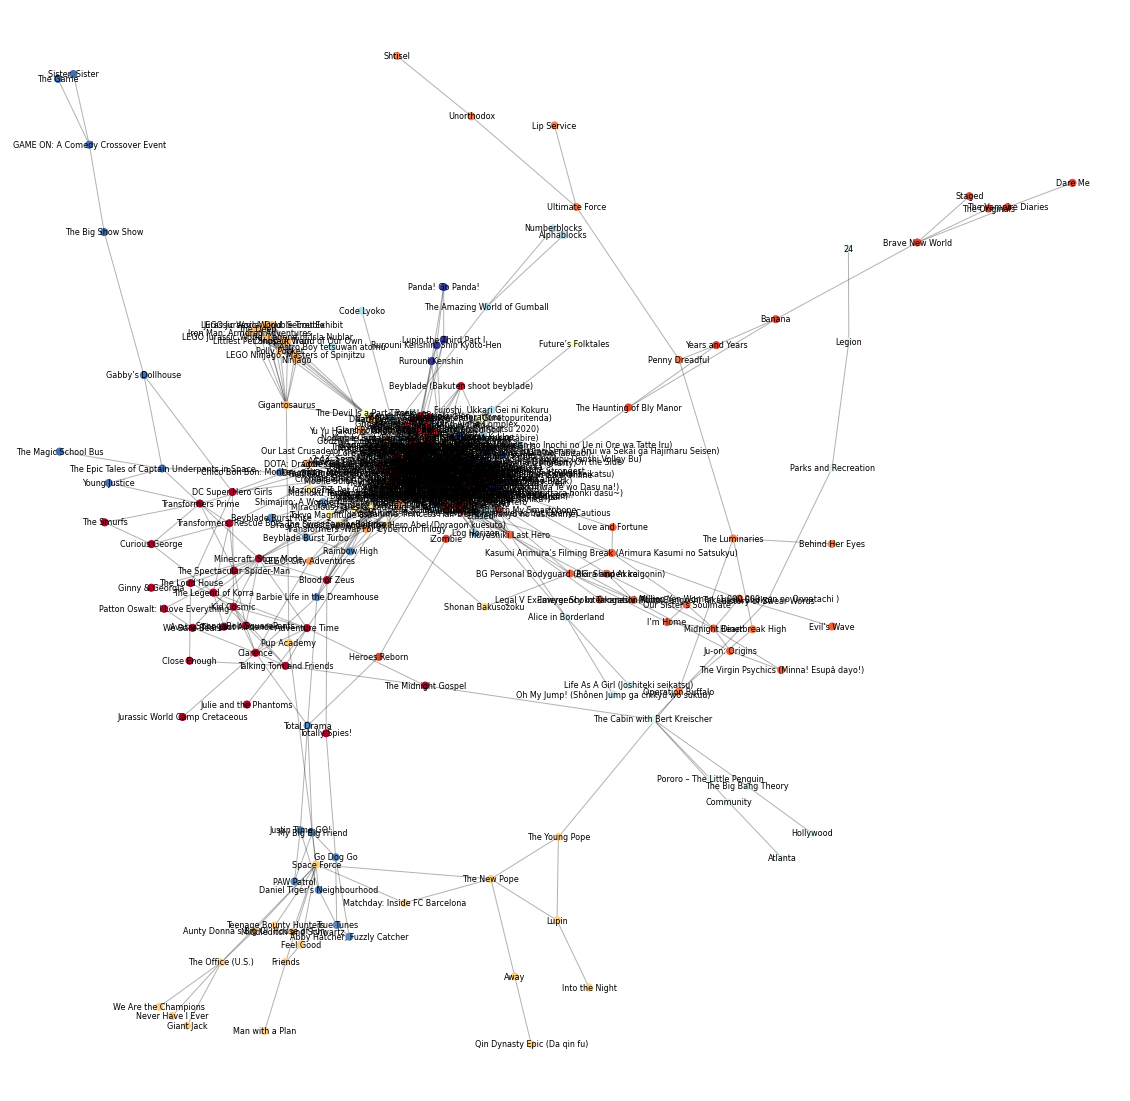

In [151]:
import community
import matplotlib.pyplot as plt
partition = community.best_partition(G)  # compute communities

pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(20, 20))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.show(G)

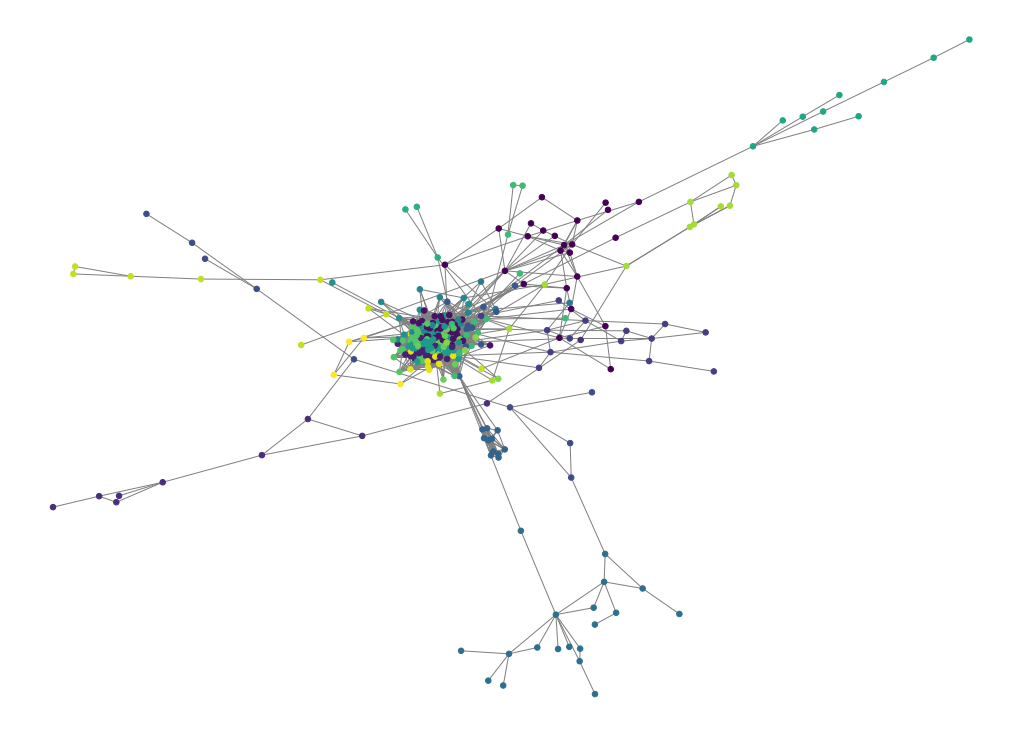

In [160]:
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G, scale=40)
d = dict(G.degree)
nx.draw(G, pos, node_color=list(partition.values()), edge_color = 'grey',
        with_labels=False, 
        nodelist=d, 
        node_size = 30)